# COMP5318: Assignment 1
## By Jesse S. Narvasa

In [1]:
# library imports

import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
from datetime import datetime

In [2]:
# Loading our training data

with h5py.File('./Input/train/images_training.h5','r') as H:
    data_train = np.copy(H['datatrain'])
with h5py.File('./Input/train/labels_training.h5','r') as H:
    label_train = np.copy(H['labeltrain'])
    
# Loading our testing data

with h5py.File('./Input/test/images_testing.h5','r') as H:
    data_test = np.copy(H['datatest'])
with h5py.File('./Input/test/labels_testing_2000.h5','r') as H:
    label_test = np.copy(H['labeltest'])

In [3]:
# Verifying our loaded training data

print(data_train.shape, label_train.shape)

(30000, 784) (30000,)


In [4]:
# Class mappings
class_mappings = {
    0: 'T-shirt/Top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

In [5]:
current_image = 1

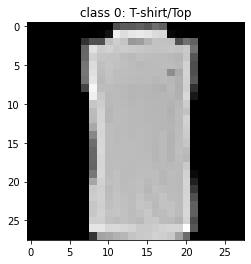

In [6]:
data_train = data_train.reshape((data_train.shape[0], 28, 28))
plt.imshow(data_train[current_image], cmap=plt.get_cmap('gray'))
plt.title("class " + str(label_train[current_image]) + ": " + class_mappings[label_train[current_image]] )
plt.show()

### Compression

#### SVD

In [ ]:
# Run SVD on it
target_data = data_train[current_image]
U, s, Vt = np.linalg.svd(target_data, full_matrices=False)
S = np.diag(s)

# We then create a dynamic component_num in which we'll use to determine how many components we'll keep
# this is determine by round to 2 decimal places, and any value that is 0 will be removed
svd_components = np.count_nonzero(np.round(s, decimals=2) > 0)

target_data_reconstructed = U[:, :svd_components]\
    .dot(S[:svd_components, :svd_components])\
    .dot(Vt[:svd_components, :])

plt.imshow(target_data_reconstructed, cmap=plt.get_cmap('gray'))
plt.title(f"After SVD using only the top {svd_components} elements")
plt.show()

# Verifying that our reconstructed matrix is approximately equal to our original matrix (within tolerance)
print(f'Is the original and reconstructed matrix approximately equal? {np.allclose(target_data, target_data_reconstructed)}')

# Checking the compression ratio of this
comp_ratio = ((U.shape[0] * svd_components) + (svd_components) + (svd_components * Vt.shape[1])) / (target_data.shape[0]*target_data.shape[1])
print(f"Our compression ratio is: {comp_ratio}")

# SSE
svd_SSE = np.sum((target_data - target_data_reconstructed)**2)
print(f"SVD SSE is: {svd_SSE}")

#### PCA

In [ ]:
# Applying mean-centering to the original dataset
target_data_mean = target_data.mean(axis=0)
target_data_mean_matrix = np.full((len(target_data_mean), len(target_data_mean)), target_data_mean)
target_data_centred = target_data - target_data_mean_matrix

# Now let's try PCA
XtX = (target_data_centred.T).dot(target_data_centred)
l, V = np.linalg.eig(XtX)
L = np.diag(l)

pca_components = np.count_nonzero(np.round(l, decimals=2) > 0)

pca_projection = target_data_centred.dot(V)
target_data_reconstructed = pca_projection[:, :pca_components]\
    .dot(V.T[:pca_components, :])\
    + target_data_mean_matrix

plt.imshow(target_data_reconstructed, cmap=plt.get_cmap('gray'))
plt.title(f"After PCA, using only {pca_components} components")
plt.show()

# SSE
pca_SSE = np.sum((target_data - target_data_reconstructed)**2)
print(f"PCA SSE is: {pca_SSE}")

### Pre-processing

#### PCA

In [21]:
def apply_pca(data):
    '''
    Apply PCA on the given dataset
    INPUT: 2D or 3D array dataset
    OUTPUT: 3D array of principal components for the given dataset
    '''
    if len(data.shape) != 3:
        data = data.reshape((data.shape[0], 28, 28))
    
    pca_data = np.zeros((data.shape[0], data.shape[1], data.shape[2]))
    
    for image_num in range(data.shape[0]):
        # Applying mean-centering to the original dataset
        image_mean = data[image_num].mean(axis=0)
        # Turning it into a matrix since above is an array
        image_mean_matrix = np.full((len(image_mean), len(image_mean)), image_mean)
        # Subtracting our actual dataset with the mean to get the centered matrix
        image_centred = data[image_num] - image_mean_matrix

        # Now let's try PCA
        XtX = (image_centred.T).dot(image_centred)
        l, V = np.linalg.eig(XtX)

        # Do the projection of the image matrix against our orthogonal eigenvector matrix
        image_projected = data[image_num].dot(V)
    
        pca_data[image_num] = image_projected
        
    return pca_data

### Classification

#### k-Nearest Neighbours

In [7]:
def knn(data_train, label_train, data_test, K=5):
    '''
    k-Nearest Neighbour classifier
    INPUT: 3D array of data_train (training dataset), 1D array of label_train (label of training dataset)
        3D array of data_test,
        (optional) K number of nearest neighbours
    OUTPUT: 1D array of predicted results with the same length as data_test.shape[0]
    '''
    
    if len(data_train.shape) != 3:
        data_train = data_train.reshape((data_train.shape[0], 28, 28))
        
    if len(data_test.shape) != 3:
        data_test = data_test.reshape((data_test.shape[0], 28, 28))
        
    pred_test = np.zeros(data_test.shape[0])
    
    for image_num in range(data_test.shape[0]):
        # Calculating the distance difference between the test subject and all our training points
        distance_diff = (np.reshape(((data_train - data_test[image_num])**2), (data_train.shape[0], 784))).sum(axis=1)
    
        # Getting the k nearest neighbours
        k_nearest_neighbours = np.argsort(distance_diff)[:K]
    
        classes_dict = {}

        # Using weighted distance, instead of simply using count
        for neighbour_idx in k_nearest_neighbours:
            classification = label_train[neighbour_idx]
            if classification in classes_dict:
                classes_dict[classification] += 1/(distance_diff[neighbour_idx]**2)
            else:
                classes_dict[classification] = 1/(distance_diff[neighbour_idx]**2)
            
        pred_class = None
        for key in classes_dict:
            if pred_class == None:
                pred_class = key
                continue

            if classes_dict[key] > classes_dict[pred_class]:
                pred_class = key
                
        pred_test[image_num] = pred_class
            
    return pred_test

In [10]:
# k-Nearest Neighbours Classifier using raw data as input
print(f"Started at: {datetime.now()}")
knn_results = knn(data_train, label_train, data_test, K=5)
print(f"Finished at: {datetime.now()}")

Started at: 2020-10-11 22:59:27.915528
Finished at: 2020-10-11 23:11:01.511374


In [20]:
correct = 0

for n in range(label_test.shape[0]):
    if knn_results[n] == label_test[n]:
        correct += 1
        
print(f"Accuracy result is: {correct/label_test.shape[0]}")

0.83


#### Naive Bayes

In [22]:
def gaussian_naive_bayes(data_train, label_train, data_test):
    '''
    Gaussian Naive Bayes classifier
    INPUT: 2D/3D array of training dataset (data_train), 2D array of label on training dataset (label_train),
        2D/3D array of test dataset (data_test)
    OUTPUT: 2D array of predicted classes on test dataset
    '''
    if len(data_train.shape) != 2:
        data_train = data_train.reshape((data_train.shape[0],784))
        
    if len(data_test.shape) != 2:
        data_test = data_test.reshape((data_test.shape[0], 784))

    class_indices = {}
    for idx, image_class in enumerate(label_train):
        if image_class not in class_indices:
            class_indices[image_class] = [idx]
            continue
        else:
            class_indices[image_class].append(idx)
        
    class_mean = {}
    class_var = {}

    for class_index in class_indices:
        mean = data_train[class_indices[class_index], :].mean(axis=0)
        var = data_train[class_indices[class_index], :].var(axis=0)
        class_mean[class_index] = mean
        class_var[class_index] = var

    pred_test = np.zeros(data_test.shape[0])

    for image_num in range(data_test.shape[0]):
        # In order to find the length of pred_class_scores, we need to get the max value of the keys
        # with the assumption that each number up to the max will be a class
        # we do this instead of length because our training data may not have an entry for a class, hence, it'll
        # result in out of range if a data exists for one higher
        pred_class_scores = np.zeros(max(class_indices, key=int)+1)
        for class_index in class_indices:
            
            # Calculating the prior probability
            class_prob = np.log(len(class_indices[class_index])/data_train.shape[0])

            for feature_num in range(data_test.shape[1]):
                # continue if the variance is 0, since it'll be constant
                if class_var[class_index][feature_num] == 0:
                    continue
                likelihood = st.norm.logpdf(x=data_test[image_num][feature_num], loc=class_mean[class_index][feature_num], scale=np.sqrt(class_var[class_index][feature_num]))
                class_prob += likelihood

            pred_class_scores[class_index] = class_prob

        pred_test[image_num] = np.nanargmax(pred_class_scores)
        
    return pred_test

In [ ]:
# Gaussian Naive Bayes using raw data as input
print(f"Started at: {datetime.now()}")
nb_results = gaussian_naive_bayes(data_train, label_train, data_test)
print(f"Finished at: {datetime.now()}")

# Gaussian Naive Bayes applied on principal components of dataset
print(f"Started at: {datetime.now()}")
pca_data_train = apply_pca(data_train)
pca_data_test = apply_pca(data_test)
nb_pca_results = gaussian_naive_bayes(pca_data_train, label_train, pca_data_test)
print(f"Finished at: {datetime.now()}")